<a href="https://colab.research.google.com/github/RoadoneP/Machine_learning/blob/main/titanic/Titanic_retry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#라이브러리

In [2]:
#load packages
import sys #access to system parameters https://docs.python.org/3/library/sys.html
print("Python version: {}". format(sys.version))

import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
print("pandas version: {}". format(pd.__version__))

import matplotlib #collection of functions for scientific and publication-ready visualization
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np #foundational package for scientific computing
print("NumPy version: {}". format(np.__version__))

import scipy as sp #collection of functions for scientific computing and advance mathematics
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
print("IPython version: {}". format(IPython.__version__)) 

import sklearn #collection of machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))

#misc libraries
import random
import time


#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output

Python version: 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
pandas version: 1.1.5
matplotlib version: 3.2.2
NumPy version: 1.19.5
SciPy version: 1.4.1
IPython version: 5.5.0
scikit-learn version: 0.22.2.post1
-------------------------


In [3]:
import numpy as np # 수치 연산
import pandas as pd # 데이터생성을 위한 라이브러리

# 데이터 시각화에 필요한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)

#
import missingno as msno

#warning 무시
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

%matplotlib inline 

In [4]:
df_raw=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
df_test=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')

In [5]:
df_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Re-F.E

In [7]:
df_train = df_raw.copy(deep = True)
df_cleaner = [df_train, df_test]

In [8]:
for dataset in df_cleaner:
  dataset['Age'].fillna(dataset['Age'].median(), inplace = True)
  dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)
  dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)

drop_column = ['PassengerId','Cabin', 'Ticket']
df_train.drop(drop_column, axis=1, inplace = True)

print(df_train.isnull().sum())
print("-"*10)
print(df_test.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [9]:
for dataset in df_cleaner:
  dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch']+1
  dataset['IsAlone'] = 1 #initialize to yes/1 is alone
  dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0;

  dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

  dataset['FareBin'] = pd.qcut(dataset['Fare'],4) #4개 부분으로 나눈다. 4 3 2 1
  dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)


stat_min = 10

title_names = (df_train['Title'].value_counts() < stat_min)
df_train['Title']= df_train['Title'].apply(lambda x:'Misc' if title_names.loc[x]== True else x)
print(df_train['Title'].value_counts())
print("-"*10)


#preview data again
df_train.info()
df_test.info()
df_train.sample(10)

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    891 non-null    int64   
 1   Pclass      891 non-null    int64   
 2   Name        891 non-null    object  
 3   Sex         891 non-null    object  
 4   Age         891 non-null    float64 
 5   SibSp       891 non-null    int64   
 6   Parch       891 non-null    int64   
 7   Fare        891 non-null    float64 
 8   Embarked    891 non-null    object  
 9   FamilySize  891 non-null    int64   
 10  IsAlone     891 non-null    int64   
 11  Title       891 non-null    object  
 12  FareBin     891 non-null    category
 13  AgeBin      891 non-null    category
dtypes: category(2), float64(2), int64(6), object(4)
memory usage: 85.8+ KB
<class 'pandas.core.frame.DataFrame'>
Ra

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
635,1,2,"Davis, Miss. Mary",female,28.0,0,0,13.0000,S,1,1,Miss,"(7.91, 14.454]","(16.0, 32.0]"
135,0,2,"Richard, Mr. Emile",male,23.0,0,0,15.0458,C,1,1,Mr,"(14.454, 31.0]","(16.0, 32.0]"
184,1,3,"Kink-Heilmann, Miss. Luise Gretchen",female,4.0,0,2,22.0250,S,3,0,Miss,"(14.454, 31.0]","(-0.08, 16.0]"
729,0,3,"Ilmakangas, Miss. Pieta Sofia",female,25.0,1,0,7.9250,S,2,0,Miss,"(7.91, 14.454]","(16.0, 32.0]"
232,0,2,"Sjostedt, Mr. Ernst Adolf",male,59.0,0,0,13.5000,S,1,1,Mr,"(7.91, 14.454]","(48.0, 64.0]"
773,0,3,"Elias, Mr. Dibo",male,28.0,0,0,7.2250,C,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
363,0,3,"Asim, Mr. Adola",male,35.0,0,0,7.0500,S,1,1,Mr,"(-0.001, 7.91]","(32.0, 48.0]"
597,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,0.0000,S,1,1,Mr,"(-0.001, 7.91]","(48.0, 64.0]"
70,0,2,"Jenkin, Mr. Stephen Curnow",male,32.0,0,0,10.5000,S,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]"
824,0,3,"Panula, Master. Urho Abraham",male,2.0,4,1,39.6875,S,6,0,Master,"(31.0, 512.329]","(-0.08, 16.0]"


**code categorical**

In [10]:
label = LabelEncoder()
for dataset in df_cleaner:
  dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
  dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
  dataset['Title_Code'] = label.fit_transform(dataset['Title'])
  dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
  dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])

Target = ['Survived']

df_train_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] #pretty name/values for charts
df_train_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare'] #coded for algorithm calculation
df_train_xy =  Target + df_train_x
print('Original X Y: ', df_train_xy, '\n')

df_train_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
df_train_xy_bin = Target + df_train_x_bin
print('Bin X Y: ', df_train_xy_bin, '\n')


#define x and y variables for dummy features original
df_train_dummy = pd.get_dummies(df_train[df_train_x])
df_train_x_dummy = df_train_dummy.columns.tolist()
df_train_xy_dummy = Target + df_train_x_dummy
print('Dummy X Y: ', df_train_xy_dummy, '\n')

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



In [11]:
df_train_dummy.head()

,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,0,1,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,0,1
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,0,1,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,0,1
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,0,1,0


In [12]:
print('Train columns with null values: \n', df_train.isnull().sum())
print("-"*10)
print (df_train.info())
print("-"*10)

print('Test/Validation columns with null values: \n', df_test.isnull().sum())
print("-"*10)
print (df_test.info())
print("-"*10)

df_raw.describe(include = 'all')

Train columns with null values: 
 Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Survived       891 non-null    int64   
 1   Pclass         891 non-null    int64   
 2   Name           891 non-null    object  
 3   Sex            891 non-null    object  
 4   Age            891 non-null    float64 
 5   SibSp          891 non-null    int64   
 6   Parch          891 non-null    int64   
 7   Fare           891 non-null    float64 
 8   Embarked       891 no

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Caldwell, Master. Alden Gates",male,NaN,NaN,NaN,1601,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [13]:
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(df_train[df_train_x_calc], df_train[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(df_train[df_train_x_bin], df_train[Target] , random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(df_train_dummy[df_train_x_dummy], df_train[Target], random_state = 0)


print("Data1 Shape: {}".format(df_train.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))
print(df_train[df_train_x_calc].head(1))
print(df_train[df_train_x_calc].head(1))
print(df_train_dummy[df_train_x_dummy].head(1))
train1_x_bin.head()

Data1 Shape: (891, 19)
Train1 Shape: (668, 8)
Test1 Shape: (223, 8)
   Sex_Code  Pclass  Embarked_Code  Title_Code  SibSp  Parch   Age  Fare
0         1       3              2           3      1      0  22.0  7.25
   Sex_Code  Pclass  Embarked_Code  Title_Code  SibSp  Parch   Age  Fare
0         1       3              2           3      1      0  22.0  7.25
   Pclass  SibSp  Parch   Age  ...  Title_Misc  Title_Miss  Title_Mr  Title_Mrs
0       3      1      0  22.0  ...           0           0         1          0

[1 rows x 17 columns]


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,3,1,1,0
68,0,3,2,2,7,1,1
253,1,3,2,3,2,1,2
320,1,3,2,3,1,1,0
706,0,2,2,4,1,2,1


In [14]:
for x in df_train_x:
    if df_train[x].dtype != 'float64' :
        print('Survival Correlation by:', x)
        print(df_train[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-'*10, '\n')
        

print(pd.crosstab(df_train['Title'],df_train[Target[0]]))

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------- 

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------- 

Survival Correlation by: Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
---------- 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------- 

Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
---------- 

Survival Correlation by: FamilySize
   FamilySize  Survived
0           1  0.303538
1 

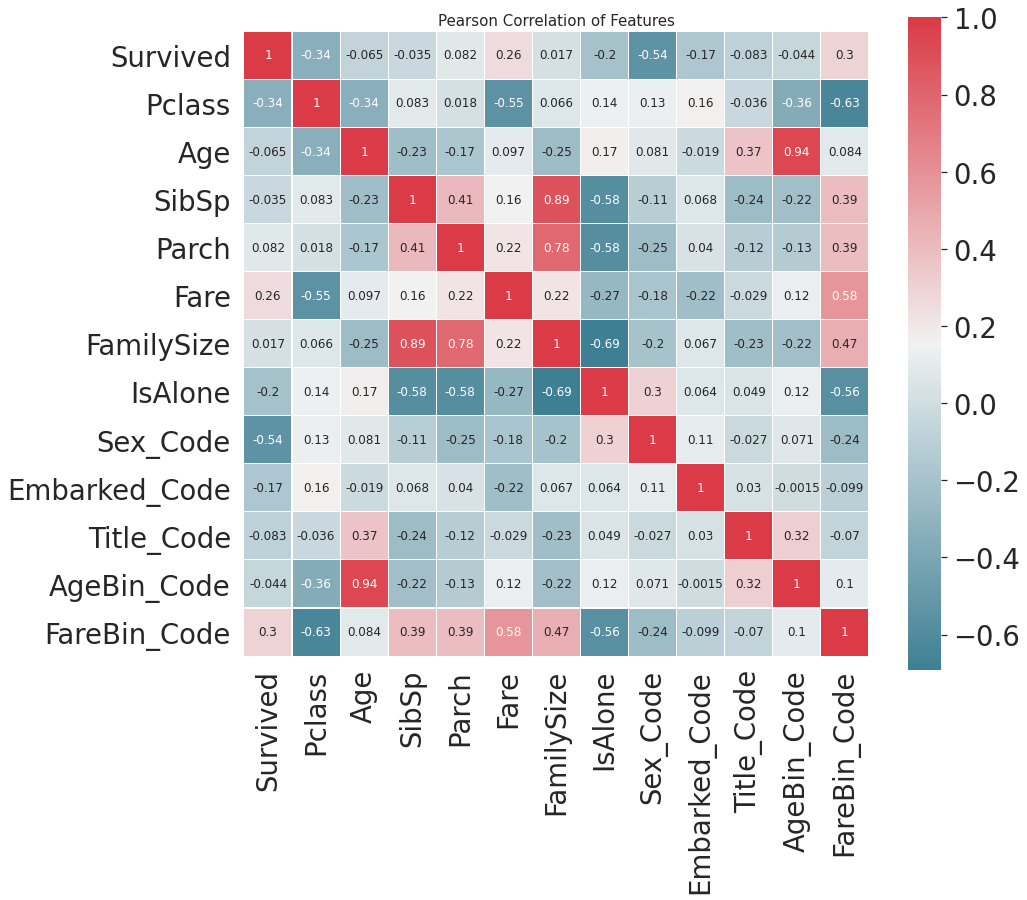

In [15]:
def correlation_heatmap(df):
    f , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    f = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(df_train)

In [16]:
#Machine Learning Algorithm

MLA =[
      ensemble.AdaBoostClassifier(),
      ensemble.BaggingClassifier(),
      ensemble.ExtraTreesClassifier(),
      ensemble.GradientBoostingClassifier(),
      ensemble.RandomForestClassifier(),

       #Gaussian Processes
      gaussian_process.GaussianProcessClassifier(),
    
      #GLM
      linear_model.LogisticRegressionCV(),
      linear_model.PassiveAggressiveClassifier(),
      linear_model.RidgeClassifierCV(),
      linear_model.SGDClassifier(),
      linear_model.Perceptron(),
    
      #Navies Bayes
      naive_bayes.BernoulliNB(),
      naive_bayes.GaussianNB(),
      
      #Nearest Neighbor
      neighbors.KNeighborsClassifier(),
      
      #SVM
      svm.SVC(probability=True),
      svm.NuSVC(probability=True),
      svm.LinearSVC(),
      
      #Trees    
      tree.DecisionTreeClassifier(),
      tree.ExtraTreeClassifier(),
      
      #Discriminant Analysis
      discriminant_analysis.LinearDiscriminantAnalysis(),
      discriminant_analysis.QuadraticDiscriminantAnalysis(),

      XGBClassifier()    
  
]

In [17]:
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 )


MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = df_train[Target]

row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    cv_results = model_selection.cross_validate(alg, df_train[df_train_x_bin], df_train[Target], cv  = cv_split, return_train_score=True)
  
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(df_train[df_train_x_bin], df_train[Target])
    MLA_predict[MLA_name] = alg.predict(df_train[df_train_x_bin])
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
21,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.856367,0.829478,0.0527546,0.104888
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.895131,0.829478,0.0643145,0.16578
14,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.835206,0.827612,0.0409157,0.0428299
15,NuSVC,"{'break_ties': False, 'cache_size': 200, 'clas...",0.834082,0.826119,0.0456629,0.0538947
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.895131,0.824627,0.0615163,0.123692
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.866667,0.822761,0.0498731,0.084684
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.891573,0.821269,0.0636093,0.0211453
17,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.895131,0.820522,0.0516505,0.00269418
18,ExtraTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.895131,0.816045,0.0648964,0.00249097
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.850375,0.813806,0.0690863,0.0029181


Text(0, 0.5, 'Algorithm')

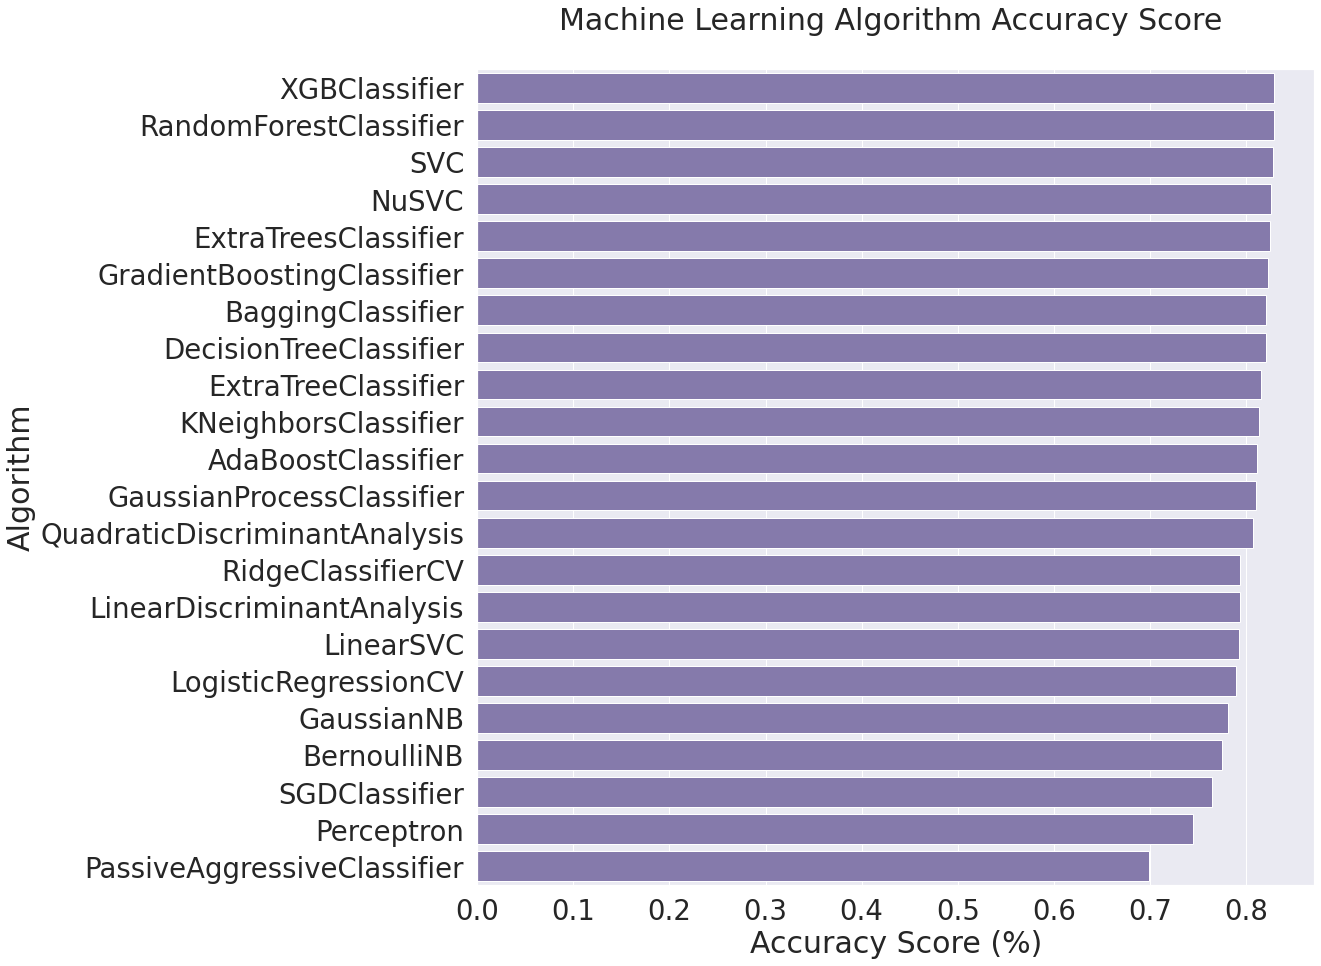

In [18]:
plt.subplots(figsize=(15,15))
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [30]:
vote_est = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc',ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),

    #Gaussian Processes: http://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-classification-gpc
    ('gpc', gaussian_process.GaussianProcessClassifier()),
    
    #GLM: http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
    ('lr', linear_model.LogisticRegressionCV()),
    
    #Navies Bayes: http://scikit-learn.org/stable/modules/naive_bayes.html
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),
    
    #Nearest Neighbor: http://scikit-learn.org/stable/modules/neighbors.html
    ('knn', neighbors.KNeighborsClassifier()),
    
    #SVM: http://scikit-learn.org/stable/modules/svm.html
    ('svc', svm.SVC(probability=True)),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
   ('xgb', XGBClassifier())

]

In [31]:
grid_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
grid_hard_cv = model_selection.cross_validate(grid_hard, df_train[df_train_x_bin], df_train[Target], cv  = cv_split,return_train_score=True)
grid_hard.fit(df_train[df_train_x_bin], df_train[Target])

print("Hard Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_hard_cv['train_score'].mean()*100)) 
print("Hard Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_hard_cv['test_score'].mean()*100))
print("Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_hard_cv['test_score'].std()*100*3))
print('-'*10)

#Soft Vote or weighted probabilities w/Tuned Hyperparameters
grid_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
grid_soft_cv = model_selection.cross_validate(grid_soft, df_train[df_train_x_bin], df_train[Target], cv  = cv_split, return_train_score=True)
grid_soft.fit(df_train[df_train_x_bin], df_train[Target])

print("Soft Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_soft_cv['train_score'].mean()*100)) 
print("Soft Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_soft_cv['test_score'].mean()*100))
print("Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_soft_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting w/Tuned Hyperparameters Training w/bin score mean: 86.61
Hard Voting w/Tuned Hyperparameters Test w/bin score mean: 82.09
Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 3.91
----------
Soft Voting w/Tuned Hyperparameters Training w/bin score mean: 87.13
Soft Voting w/Tuned Hyperparameters Test w/bin score mean: 82.43
Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 4.43
----------


In [32]:
def mytree(df):
    
    #initialize table to store predictions
    Model = pd.DataFrame(data = {'Predict':[]})
    male_title = ['Master'] #survived titles

    for index, row in df.iterrows():

        #Question 1: Were you on the Titanic; majority died
        Model.loc[index, 'Predict'] = 0

        #Question 2: Are you female; majority survived
        if (df.loc[index, 'Sex'] == 'female'):
                  Model.loc[index, 'Predict'] = 1

        #Question 3A Female - Class and Question 4 Embarked gain minimum information

        #Question 5B Female - FareBin; set anything less than .5 in female node decision tree back to 0       
        if ((df.loc[index, 'Sex'] == 'female') & 
            (df.loc[index, 'Pclass'] == 3) & 
            (df.loc[index, 'Embarked'] == 'S')  &
            (df.loc[index, 'Fare'] > 8)

           ):
                  Model.loc[index, 'Predict'] = 0

        #Question 3B Male: Title; set anything greater than .5 to 1 for majority survived
        if ((df.loc[index, 'Sex'] == 'male') &
            (df.loc[index, 'Title'] in male_title)
            ):
            Model.loc[index, 'Predict'] = 1
        
        
    return Model

In [34]:
print(df_test.info())
print("-"*10)


df_test['Survived'] = mytree(df_test).astype(int)

df_test['Survived'] = grid_hard.predict(df_test[df_train_x_bin])

submit = df_test[['PassengerId','Survived']]
submit.to_csv("/content/drive/MyDrive/Colab Notebooks/Titanic/submit.csv", index=False)

print('Validation Data Distribution: \n', df_test['Survived'].value_counts(normalize = True))
submit.sample(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PassengerId    418 non-null    int64   
 1   Pclass         418 non-null    int64   
 2   Name           418 non-null    object  
 3   Sex            418 non-null    object  
 4   Age            418 non-null    float64 
 5   SibSp          418 non-null    int64   
 6   Parch          418 non-null    int64   
 7   Ticket         418 non-null    object  
 8   Fare           418 non-null    float64 
 9   Cabin          91 non-null     object  
 10  Embarked       418 non-null    object  
 11  FamilySize     418 non-null    int64   
 12  IsAlone        418 non-null    int64   
 13  Title          418 non-null    object  
 14  FareBin        418 non-null    category
 15  AgeBin         418 non-null    category
 16  Sex_Code       418 non-null    int64   
 17  Embarked_Code  418 non-null    int6

,PassengerId,Survived
393,1285,0
369,1261,0
53,945,1
92,984,1
50,942,0
228,1120,0
115,1007,0
405,1297,0
214,1106,0
158,1050,1


**Voting Calssifiers 사용**
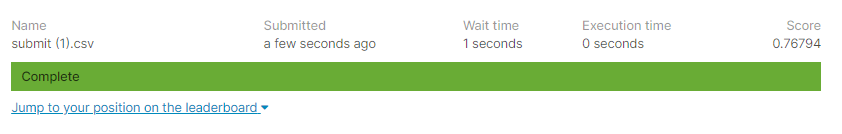